# Offline RL (80 Points)

> Name:

> SID:




In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy.

In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

*The existing results are the baseline for the quality of your implementation.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm
import pickle



seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Network Structure (10 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [3]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO
        # Define your network layers
        self.fc1 = nn.Linear(input_dimension, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_dimension)
        self.output_activation = output_activation
        ##########################################################

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO
        # Calculate the output
        x = F.relu(self.fc1(inpt))
        x = F.relu(self.fc2(x))
        output = self.output_activation(self.fc3(x))
        ##########################################################

        return output

## Replay Buffer

A SAC agent requires a replay buffer to sample previously visited states. You can utilize the implemented code below to set up this replay buffer.

In [4]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [5]:
class SACAgent:
    def __init__(self, environment, replay_buffer=None, offline=False, learning_rate=3e-4, discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.alpha_init = alpha_init
        self.learning_rate = learning_rate
        self.discount = discount
        self.buffer_batch_size = buffer_batch_size
        self.interpolation_factor = interpolation_factor

        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.offline = offline

        ##########################################################
        # TODO
        # Define critics usig your implemented feed forward netwrok
        ##########################################################
        self.critic_local = Network(self.state_dim, self.action_dim)
        self.critic_local2 = Network(self.state_dim, self.action_dim)
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=self.learning_rate)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=self.learning_rate)
        self.critic_target = Network(self.state_dim, self.action_dim)
        self.critic_target2 = Network(self.state_dim, self.action_dim)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO
        # Define the actor
        # Define the actor optimizer
        ##########################################################
        self.actor_local = Network(self.state_dim, self.action_dim, output_activation=nn.Softmax(dim=-1))
        self.actor_optimiser = optim.Adam(self.actor_local.parameters(), lr=self.learning_rate)
        ##########################################################
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO
        # You are going to calculate critic losses in this method
        ##########################################################
        with torch.no_grad():
            next_action_probs, next_log_probs = self.get_action_info(next_states_tensor)
            next_q_values = self.critic_target(next_states_tensor)
            next_q_values2 = self.critic_target2(next_states_tensor)
            min_next_q_values = torch.min(next_q_values, next_q_values2)
            soft_state_values = (next_action_probs * (min_next_q_values - self.alpha.detach() * next_log_probs)).sum(dim=1)
            next_q_values = rewards_tensor + (1 - done_tensor.float()) * self.discount * soft_state_values

        q_values = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        q_values2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)

        critic_loss = F.mse_loss(q_values, next_q_values)
        critic2_loss = F.mse_loss(q_values2, next_q_values)

        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor, actions_tensor):
        ##########################################################
        # TODO
        # Implement the actor loss
        ##########################################################
        action_probs, log_action_probabilities = self.get_action_info(states_tensor)
        q_values = self.critic_local(states_tensor)
        q_values2 = self.critic_local2(states_tensor)
        min_q_values = torch.min(q_values, q_values2)

        inside_term = self.alpha.detach() * log_action_probabilities - min_q_values
        actor_loss = (action_probs * inside_term).sum(dim=1).mean()

        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO
        # Set all the gradients stored in the optimizers to zero
        # Add the new transition to the replay buffer for online case
        ##########################################################
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()

        if not self.offline and transition is not None:
            self.replay_buffer.add_transition(transition)

        if self.replay_buffer.get_size() >= self.buffer_batch_size:
            minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size, batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
            # TODO
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it
            # You also need to update \alpha
            ##########################################################
            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)
            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probs = self.actor_loss(states_tensor, actions_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probs)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks(self.interpolation_factor)

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state, action):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

    def save_replay_buffer(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.replay_buffer, f)
        print(f"Replay buffer saved to {filename}")

    @classmethod
    def load_replay_buffer(cls, environment, filename):
        with open(filename, 'rb') as f:
            replay_buffer = pickle.load(f)
        print(f"Replay buffer loaded from {filename}")
        return cls(environment, replay_buffer=replay_buffer, offline=True)

## Online SAC (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

Run 1


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 4: Evaluation Reward: 9.3
Episode 8: Evaluation Reward: 10.6
Episode 12: Evaluation Reward: 9.1
Episode 16: Evaluation Reward: 63.4
Episode 20: Evaluation Reward: 25.8
Episode 24: Evaluation Reward: 143.7
Episode 28: Evaluation Reward: 195.2
Episode 32: Evaluation Reward: 197.3
Episode 36: Evaluation Reward: 200.0
Episode 40: Evaluation Reward: 199.5
Episode 44: Evaluation Reward: 192.4
Episode 48: Evaluation Reward: 198.9
Episode 52: Evaluation Reward: 198.6
Episode 56: Evaluation Reward: 195.8
Episode 60: Evaluation Reward: 192.6
Episode 64: Evaluation Reward: 195.5
Episode 68: Evaluation Reward: 195.9
Episode 72: Evaluation Reward: 197.9
Episode 76: Evaluation Reward: 200.0
Episode 80: Evaluation Reward: 200.0
Episode 84: Evaluation Reward: 195.3
Episode 88: Evaluation Reward: 197.4
Episode 92: Evaluation Reward: 198.9
Episode 96: Evaluation Reward: 199.0
Episode 100: Evaluation Reward: 199.8
Replay buffer saved to sac_replay_buffer_run_1.pkl
Run 2
Episode 4: Evaluation Rewa

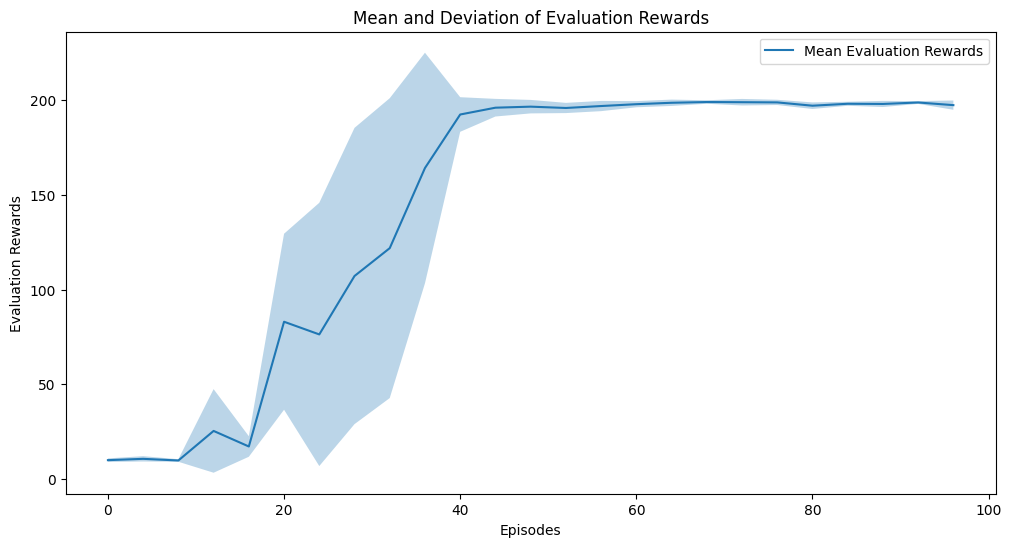

In [6]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 100
STEPS_PER_EPISODE = 200
env = gym.make("CartPole-v1", new_step_api=True)

##########################################################
# TODO
# Implement the training loop for the online SAC.
# After each epoch, run validation
# and plot the mean return over these
# episodes in the end
# Plot the learning curves
##########################################################

# Training and evaluation loop
def train_and_evaluate(agent, env, training_episodes, steps_per_episode, evaluation_ratio):
    training_rewards = []
    evaluation_rewards = []

    for episode in range(training_episodes):
        # Handle both old and new Gym reset() return types
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]
        else:
            state = reset_result

        episode_reward = 0

        for step in range(steps_per_episode):
            action = agent.get_next_action(state)
            step_result = env.step(action)

            # Handle both old and new Gym step() return types
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated

            agent.train_on_transition(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward
            if done:
                break

        training_rewards.append(episode_reward)

        if (episode + 1) % evaluation_ratio == 0:
            eval_reward = evaluate_agent(agent, env, steps_per_episode)
            evaluation_rewards.append(eval_reward)
            print(f"Episode {episode + 1}: Evaluation Reward: {eval_reward}")

    return training_rewards, evaluation_rewards

def evaluate_agent(agent, env, steps_per_episode, num_episodes=10):
    total_reward = 0
    for _ in range(num_episodes):
        # Handle both old and new Gym reset() return types
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]
        else:
            state = reset_result

        episode_reward = 0
        for _ in range(steps_per_episode):
            action = agent.get_next_action(state, evaluation_episode=True)
            step_result = env.step(action)

            # Handle both old and new Gym step() return types
            if len(step_result) == 4:
                state, reward, done, _ = step_result
            else:
                state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated

            episode_reward += reward
            if done:
                break
        total_reward += episode_reward
    return total_reward / num_episodes

def plot_learning_curves(training_rewards, evaluation_rewards, evaluation_ratio):
    plt.figure(figsize=(12, 6))
    plt.plot(training_rewards, label='Training Rewards')
    eval_x = np.arange(len(evaluation_rewards)) * evaluation_ratio
    plt.plot(eval_x, evaluation_rewards, label='Evaluation Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.title('Training and Evaluation Rewards')
    plt.show()

# Main loop to run the training and evaluation multiple times and plot the results
all_training_rewards = []
all_evaluation_rewards = []

for run in range(4):
    print(f"Run {run + 1}")
    agent = SACAgent(env)
    training_rewards, evaluation_rewards = train_and_evaluate(agent, env, EPISODES_PER_RUN, STEPS_PER_EPISODE, TRAINING_EVALUATION_RATIO)
    all_training_rewards.append(training_rewards)
    all_evaluation_rewards.append(evaluation_rewards)
    agent.save_replay_buffer(f'sac_replay_buffer_run_{run+1}.pkl')

# Calculate mean and standard deviation of evaluation rewards
mean_evaluation_rewards = np.mean(all_evaluation_rewards, axis=0)
std_evaluation_rewards = np.std(all_evaluation_rewards, axis=0)

# Plot the mean and deviation of the evaluation curves
plt.figure(figsize=(12, 6))
eval_x = np.arange(len(mean_evaluation_rewards)) * TRAINING_EVALUATION_RATIO
plt.plot(eval_x, mean_evaluation_rewards, label='Mean Evaluation Rewards')
plt.fill_between(eval_x, mean_evaluation_rewards - std_evaluation_rewards, mean_evaluation_rewards + std_evaluation_rewards, alpha=0.3)
plt.xlabel('Episodes')
plt.ylabel('Evaluation Rewards')
plt.legend()
plt.title('Mean and Deviation of Evaluation Rewards')
plt.show()

# offline_agent = SACAgent.load_replay_buffer(env, 'sac_replay_buffer_run_1.pkl')


In [7]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    action = agent.get_next_action(state, evaluation_episode=True) # TODO
    state, reward, done, info = env.step(action)
    if done:
        break

env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Offline SAC (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

Replay buffer loaded from sac_replay_buffer_run_4.pkl
Episode 4: Evaluation Reward: 34.3
Episode 8: Evaluation Reward: 9.2
Episode 12: Evaluation Reward: 9.6
Episode 16: Evaluation Reward: 9.4
Episode 20: Evaluation Reward: 9.4
Episode 24: Evaluation Reward: 9.6
Episode 28: Evaluation Reward: 52.8
Episode 32: Evaluation Reward: 98.4
Episode 36: Evaluation Reward: 55.6
Episode 40: Evaluation Reward: 71.2
Episode 44: Evaluation Reward: 93.9
Episode 48: Evaluation Reward: 146.4
Episode 52: Evaluation Reward: 111.8
Episode 56: Evaluation Reward: 174.0
Episode 60: Evaluation Reward: 192.9
Episode 64: Evaluation Reward: 200.0
Episode 68: Evaluation Reward: 200.0
Episode 72: Evaluation Reward: 200.0
Episode 76: Evaluation Reward: 189.0
Episode 80: Evaluation Reward: 190.7
Episode 84: Evaluation Reward: 195.0
Episode 88: Evaluation Reward: 198.3
Episode 92: Evaluation Reward: 198.3
Episode 96: Evaluation Reward: 196.6
Episode 100: Evaluation Reward: 198.6


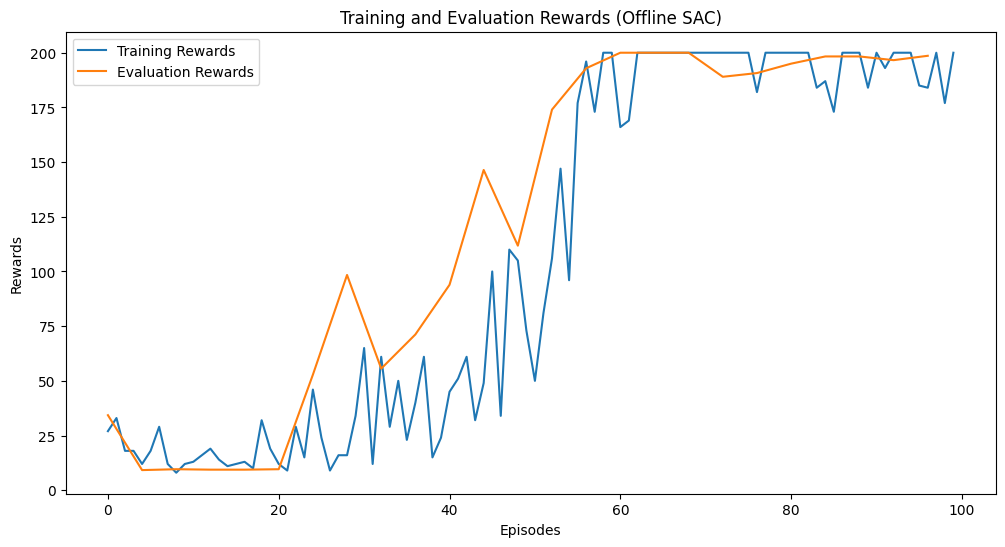

In [8]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO
# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################
# Define the Network, ReplayBuffer, and SACAgent classes (as previously implemented)

def train_and_evaluate_offline(agent, env, training_episodes, steps_per_episode, evaluation_ratio):
    training_rewards = []
    evaluation_rewards = []

    for episode in range(training_episodes):
        # Handle both old and new Gym reset() return types
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]
        else:
            state = reset_result

        episode_reward = 0

        for step in range(steps_per_episode):
            action = agent.get_next_action(state, evaluation_episode=False)
            step_result = env.step(action)

            # Handle both old and new Gym step() return types
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated

            agent.train_on_transition(state, action, next_state, reward, done)
            state = next_state
            episode_reward += reward
            if done:
                break

        training_rewards.append(episode_reward)

        if (episode + 1) % evaluation_ratio == 0:
            eval_reward = evaluate_agent(agent, env, steps_per_episode)
            evaluation_rewards.append(eval_reward)
            print(f"Episode {episode + 1}: Evaluation Reward: {eval_reward}")

    return training_rewards, evaluation_rewards

def evaluate_agent(agent, env, steps_per_episode, num_episodes=10):
    total_reward = 0
    for _ in range(num_episodes):
        # Handle both old and new Gym reset() return types
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]
        else:
            state = reset_result

        episode_reward = 0
        for _ in range(steps_per_episode):
            action = agent.get_next_action(state, evaluation_episode=True)
            step_result = env.step(action)

            # Handle both old and new Gym step() return types
            if len(step_result) == 4:
                state, reward, done, _ = step_result
            else:
                state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated

            episode_reward += reward
            if done:
                break
        total_reward += episode_reward
    return total_reward / num_episodes

# Load the saved replay buffer
env = gym.make("CartPole-v1", new_step_api=True)
offline_agent = SACAgent.load_replay_buffer(env, 'sac_replay_buffer_run_4.pkl')

# Train the offline agent
training_rewards, evaluation_rewards = train_and_evaluate_offline(offline_agent, env, EPISODES_PER_RUN, STEPS_PER_EPISODE, TRAINING_EVALUATION_RATIO)

# Plot the learning curves
plt.figure(figsize=(12, 6))
plt.plot(training_rewards, label='Training Rewards')
eval_x = np.arange(len(evaluation_rewards)) * TRAINING_EVALUATION_RATIO
plt.plot(eval_x, evaluation_rewards, label='Evaluation Rewards')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.title('Training and Evaluation Rewards (Offline SAC)')
plt.show()

In [9]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    action = offline_agent.get_next_action(state, evaluation_episode=True) # TODO
    state, reward, done, info = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./offline.mp4', frames, fps=25)
show_video('./offline.mp4')

 # Behavioural Cloning (20 points)

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

We first need to collect data using the previously trained model.

In [11]:
env = gym.make('CartPole-v1')
num_episodes = 1000
expert_data = []

# TODO
# Collect state-action pairs
env = gym.make('CartPole-v1', new_step_api=True)
num_episodes = 1000
expert_data = []

for _ in range(num_episodes):
    state = env.reset()
    episode_data = []
    done = False
    while not done:
        action = offline_agent.get_next_action(state, evaluation_episode=True)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_data.append((state, action))
        state = next_state
    expert_data.extend(episode_data)

print(f"Collected {len(expert_data)} state-action pairs from the expert.")

Collected 234774 state-action pairs from the expert.


Define the model for behaviuoral cloning.

In [12]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
        # TODO
        # Define the model
        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # TODO
        # Perform forward pass
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output

In this section, we implement the training loop for behavioral cloning. During each iteration, we sample a minibatch of state-action pairs from the expert dataset. This minibatch is then used to update the model.

In [20]:
bc_model = BCModel(input_dimension=env.observation_space.shape[0], hidden_dimension=256, output_dimension=env.action_space.n)
criterion = nn.MSELoss()
optimizer = optim.Adam(bc_model.parameters(), lr=3e-4)

num_epochs = 500
batch_size = 64

for epoch in range(num_epochs):
    total_loss = 0

    # Sample a minibatch of state-action pairs from the expert dataset
    batch_indices = np.random.choice(len(expert_data), size=batch_size, replace=False)
    batch_states = torch.tensor([expert_data[i][0] for i in batch_indices], dtype=torch.float32)
    batch_actions = torch.tensor([expert_data[i][1] for i in batch_indices], dtype=torch.long)

    # Forward pass
    predicted_actions = bc_model(batch_states)

    # Compute the loss
    loss = criterion(predicted_actions, F.one_hot(batch_actions, num_classes=env.action_space.n).float())

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / batch_size:.4f}')

Epoch 1/500, Loss: 0.0112
Epoch 2/500, Loss: 0.0115
Epoch 3/500, Loss: 0.0112
Epoch 4/500, Loss: 0.0112
Epoch 5/500, Loss: 0.0106
Epoch 6/500, Loss: 0.0105
Epoch 7/500, Loss: 0.0102
Epoch 8/500, Loss: 0.0096
Epoch 9/500, Loss: 0.0092
Epoch 10/500, Loss: 0.0091
Epoch 11/500, Loss: 0.0093
Epoch 12/500, Loss: 0.0086
Epoch 13/500, Loss: 0.0087
Epoch 14/500, Loss: 0.0078
Epoch 15/500, Loss: 0.0078
Epoch 16/500, Loss: 0.0082
Epoch 17/500, Loss: 0.0074
Epoch 18/500, Loss: 0.0074
Epoch 19/500, Loss: 0.0073
Epoch 20/500, Loss: 0.0073
Epoch 21/500, Loss: 0.0070
Epoch 22/500, Loss: 0.0071
Epoch 23/500, Loss: 0.0070
Epoch 24/500, Loss: 0.0066
Epoch 25/500, Loss: 0.0064
Epoch 26/500, Loss: 0.0066
Epoch 27/500, Loss: 0.0063
Epoch 28/500, Loss: 0.0061
Epoch 29/500, Loss: 0.0059
Epoch 30/500, Loss: 0.0059
Epoch 31/500, Loss: 0.0057
Epoch 32/500, Loss: 0.0055
Epoch 33/500, Loss: 0.0055
Epoch 34/500, Loss: 0.0057
Epoch 35/500, Loss: 0.0055
Epoch 36/500, Loss: 0.0052
Epoch 37/500, Loss: 0.0053
Epoch 38/5

Evaluate and render the results.

In [22]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state = env.reset()
for _ in range(100):
    frames.append(env.render()[0])
    state = torch.tensor(state).unsqueeze(0)
    action_probs = bc_model(state)
    action = torch.argmax(action_probs, dim=1).item()
    state, reward, done, info = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')